In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as pyo

cf.go_offline()

%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from neuralforecast.auto import AutoLSTM
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta

In [2]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoCES, AutoETS
from statsforecast.arima import arima_string

In [10]:
class FixedARIMAProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecast = None
        self.plotting_df = pd.DataFrame()
        
        self.mae = None
        self.mse = None
        self.mape = None
        self.nmse = None
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
    
    def create_fixed_model(self, h, freq, season_length, model_name, level = []):
        self.sf = StatsForecast(models=[AutoARIMA(season_length=season_length)], freq = freq)
        
        #    self.sf = StatsForecast(models=[AutoCES(season_length=season_length)], freq = freq)
        #    self.sf = StatsForecast(models=[AutoETS(model = "AZN")], freq = freq)
        
        self.sf.fit(self.dfs[0])
        
        start_date = datetime.strptime(self.dates[0], "%Y-%m-%d")
        ending_date = datetime.strptime(self.dates[-1], "%Y-%m-%d") + timedelta(weeks = h)

        prediction_horizon = abs((ending_date - start_date).days) // 7
        
        if not level:
            self.forecast = self.sf.predict(h = prediction_horizon)
        else:
            self.forecast = self.sf.predict(h = prediction_horizon, level = level)
        self.forecast.set_index("ds", inplace = True)
        
        self.sf.save(path = f"AutoARIMA/fixed_models/{model_name}")
        
    
    def create_graph(self):
        self.plotting_df.index = self.overall_df.index
        self.plotting_df["Real Data"] = self.overall_df[self.overall_df_value_col]
        

        self.plotting_df[f"Fixed ARIMA Prediction Prediction"] = self.forecast["AutoARIMA"]

       #     self.plotting_df[f"Fixed {self.model_type} Model"] = self.forecast["CES"]

         #   self.plotting_df[f"Fixed {self.model_type} Model"] = self.forecast["AutoETS"]
        
        self.plotting_df.iplot(xTitle = "Date", yTitle = "Count", title = f"Fixed Parameter ARIMA Predictions")
    
    def create_metrics(self):
        col_string = "AutoARIMA"
        


#            col_string = "CES"

 #           col_string = "AutoETS"
        
        self.mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecast.index], self.forecast[col_string])
        self.nmse = self.mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecast.index])

    def create_metrics_df(self):
        self.metrics_df.loc[len(self.metrics_df)] = [self.dates[0], self.mae, self.mse, self.mape, self.nmse]
    
    def create_display_df(self):
        for index, row in self.forecast.iterrows():
            reference_date = self.dates[0]
            target_end_date = index
            value = row[1]
            self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, value]

In [11]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [12]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [13]:
Processor = FixedARIMAProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [14]:
Processor.create_training_dfs(value_col = "value")

In [15]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", season_length = 52, model_name = "testing", level = [80, 95])

Saving StatsForecast object of size 103.33KB.
StatsForecast object saved


In [26]:
Processor.forecast

,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,
2024-10-12,series_1,383.968968,-1982.920798,-1163.657064,1931.595000,2750.858734
2024-10-19,series_1,796.491076,-3982.224923,-2328.143365,3921.125518,5575.207076
2024-10-26,series_1,1073.112714,-5523.672125,-3240.293045,5386.518473,7669.897554
2024-11-02,series_1,1664.676194,-6352.376957,-3577.393098,6906.745485,9681.729344
2024-11-09,series_1,2565.875155,-6323.704356,-3246.708459,8378.458768,11455.454666
2024-11-16,series_1,3424.084329,-5979.289690,-2724.451456,9572.620114,12827.458348
2024-11-23,series_1,4405.929947,-5223.028632,-1890.107653,10701.967548,14034.888527
2024-11-30,series_1,6045.026852,-3664.356302,-303.597551,12393.651256,15754.410007
2024-12-07,series_1,7614.176343,-2106.877487,1257.920895,13970.431790,17335.230172


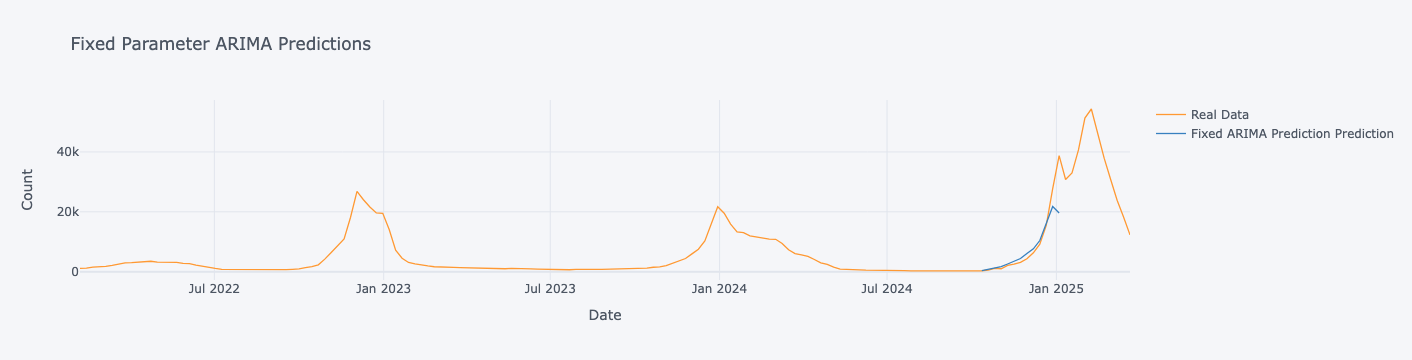

In [27]:
Processor.create_graph()

In [17]:
Processor.create_metrics()

In [18]:
Processor.create_metrics_df()

In [19]:
Processor.metrics_df

,Reference Date,MAE,MSE,MAPE,NMSE
0,2024-10-05,2574.184858,3.168088e+07,0.303065,0.241418


In [20]:
Processor.create_display_df()

In [21]:
Processor.display_df

,Reference Date,Target End Date,Prediction
0,2024-10-05,2024-10-12,383.968968
1,2024-10-05,2024-10-19,796.491076
2,2024-10-05,2024-10-26,1073.112714
3,2024-10-05,2024-11-02,1664.676194
4,2024-10-05,2024-11-09,2565.875155
5,2024-10-05,2024-11-16,3424.084329
6,2024-10-05,2024-11-23,4405.929947
7,2024-10-05,2024-11-30,6045.026852
8,2024-10-05,2024-12-07,7614.176343
9,2024-10-05,2024-12-14,10402.966640


In [3]:
class UpdatingARIMAProcessor:
    def __init__(self, overall_df, dates):
        self.overall_df = overall_df
        self.overall_df_value_col = "value"
        self.dates = dates
        
        self.dfs = []
        self.sf = None
        self.forecasts = []
        self.plotting_df = pd.DataFrame()
        
        self.maes = []
        self.mses = []
        self.mapes = []
        self.nmses = []
        
        self.metrics_df = pd.DataFrame(columns = ["Reference Date", "MAE", "MSE", "MAPE", "NMSE"])
        self.display_df = pd.DataFrame(columns = ["Reference Date", "Target End Date", "Prediction"])
    
    def create_training_dfs(self, value_col):
        self.overall_df_value_col = value_col
        for date in self.dates:
            df = self.overall_df.loc[:date]
            df['ds'] = df.index
            df["unique_id"] = "series_1"
            df = df.rename(columns = {value_col: "y"})
            self.dfs.append(df)
            
    def create_models(self, h, freq, season_length, model_names, level = []):

        self.sf = StatsForecast(models=[AutoARIMA(season_length=season_length)], freq = freq)
      
        for i in range(len(self.dfs)):
            self.sf.fit(self.dfs[i])
            fc = pd.DataFrame()
            if not level:
                fc = self.sf.predict(h = prediction_horizon)
            else:
                fc = self.sf.predict(h = prediction_horizon, level = level)
            
            fc.set_index("ds", inplace = True)
            self.forecasts.append(fc)
            #self.sf.save(path = f"./{self.model_type}/updating_models/{model_names[i]}.ckpt")
    
    def create_graph(self):
        self.plotting_df.index = self.overall_df.index
        self.plotting_df["Real Data"] = self.overall_df[self.overall_df_value_col]
        
        for i in range(len(self.forecasts)):
            date_obj = datetime.strptime(self.dates[i], "%Y-%m-%d")
            english_date = date_obj.strftime("%B %d, %Y")
            

            self.plotting_df[f"{english_date} Model"] = self.forecasts[i]["AutoARIMA"]

        self.plotting_df.iplot(xTitle = "Date", yTitle = "Count", title = f"Fixed Parameter ARIMA Predictions")
        
    def calculate_metrics(self):
        col_string = "AutoARIMA"
      
        for i in range(len(self.forecasts)):
            mae = mean_absolute_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mse = mean_squared_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            mape = mean_absolute_percentage_error(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index], self.forecasts[i][col_string])
            nmse = mse/np.var(self.overall_df[self.overall_df_value_col].loc[self.forecasts[i].index])
            
            self.maes.append(mae)
            self.mses.append(mse)
            self.mapes.append(mape)
            self.nmses.append(nmse)
    
    def create_metrics_df(self):
        for i in range(len(self.dates)):
            self.metrics_df.loc[len(self.metrics_df)] = [self.dates[i], self.maes[i], self.mses[i], self.mapes[i], self.nmses[i]]
    
    def create_display_df(self):
        for i in range(len(self.forecasts)):
            for index, row in self.forecasts[i].iterrows():
                reference_date = self.dates[i]
                target_end_date = index
                value = row[1]
                self.display_df.loc[len(self.display_df)] = [reference_date, target_end_date, value]

In [ ]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")

In [ ]:
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)

In [ ]:
UProcessor = UpdatingAUTOModelProcessor(overall_df = updated_df, dates = ["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"], model_type = "ETS")

In [ ]:
UProcessor.create_training_dfs(value_col = "value")

In [ ]:
UProcessor.create_models(h = 4, freq = "W-SAT", season_length = 52, model_name = "test")

In [ ]:
UProcessor.forecasts[4]

In [ ]:
UProcessor.create_graph()

In [ ]:
UProcessor.calculate_metrics()

In [ ]:
UProcessor.create_metrics_df()

In [ ]:
UProcessor.create_display_df()

In [ ]:
UProcessor.metrics_df

In [ ]:
UProcessor.display_df

In [22]:
StatsForecast.save?

Signature:
StatsForecast.save(
    self,
    path: Union[pathlib.Path, str, NoneType] = None,
    max_size: Optional[str] = None,
    trim: bool = False,
)
Docstring:
Function that will save StatsForecast class with certain settings to make it
reproducible.

Parameters
----------
path : str or pathlib.Path, optional (default=None)
    Path of the file to be saved. If `None` will create one in the current
    directory using the current UTC timestamp.
max_size : str, optional (default = None)
    StatsForecast object should not exceed this size.
    Available byte naming: ['B', 'KB', 'MB', 'GB']
trim : bool (default = False)
    Delete any attributes not needed for inference.
File:      ~/.local/lib/python3.11/site-packages/statsforecast/core.py
Type:      function

In [21]:
AutoARIMA.save?

Object `AutoARIMA.save` not found.


In [16]:
sf = StatsForecast(models=[AutoARIMA(season_length=52)], freq = "W-SAT")

In [17]:
sf.load(f"AutoARIMA/fixed_models/testing")

StatsForecast(models=[AutoARIMA])